# Autoencoder

- Using the MNIST dataset

## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# pytorch imports
from torch.utils.data import DataLoader as dloader
from torch import nn, cuda, device, max, save, load, no_grad, randint, float32
from torch.optim import Adam, SGD
from torch.autograd import Variable as variable
from torchvision.datasets import MNIST as mnist
from torchvision.transforms import ToTensor as tensor

## Constants

In [11]:
BATCH_SIZE = 64
LEARNING_RATE = .005
EPOCHS = 20

INPUT_DIM = 784
H1_DIM = 128
H2_DIM = 64
H3_DIM = 18
CODE_DIM = 3

## Dataset

In [12]:
# download the MNIST dataset
train_data = mnist("data", train=True, transform=tensor(), download=True)
test_data = mnist("data", train=False, transform=tensor(), download=True)

In [13]:
# load sampler and make the dataset batch iterable
train_loader = dloader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dloader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## Model fit

In [14]:
# use GPU if available; otherwise, use CPU
dev = device('cuda:0') if cuda.is_available() else device('cpu')
print(f"Training will be done with '{dev.type}'.")

Training will be done with 'cpu'.


In [15]:
class Autoencoder(nn.Module):
    def __init__(self,
                 input_dim,
                 h1_dim,
                 h2_dim,
                 h3_dim,
                 code_dim,
                 activation=nn.Identity):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h1_dim),
            activation(),
            nn.Linear(h1_dim, h2_dim),
            activation(),
            nn.Linear(h2_dim, h3_dim),
            activation(),
            nn.Linear(h3_dim, code_dim)
        )
        # use sigmoid at the end to convert values to a [0,1] "pixel intensity" scale
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, h3_dim),
            activation(),
            nn.Linear(h3_dim, h2_dim),
            activation(),
            nn.Linear(h2_dim, h1_dim),
            activation(),
            nn.Linear(h1_dim, input_dim),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        # encode then decode
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [16]:
# initialize a (AE) model object and 
model_linear = Autoencoder(INPUT_DIM, H1_DIM, H2_DIM, H3_DIM, CODE_DIM, nn.Identity)
model_tanh = Autoencoder(INPUT_DIM, H1_DIM, H2_DIM, H3_DIM, CODE_DIM, nn.Tanh)
model_relu = Autoencoder(INPUT_DIM, H1_DIM, H2_DIM, H3_DIM, CODE_DIM, nn.ReLU)
models = [model_linear, model_tanh, model_relu]

In [17]:
# loss functions
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.MSELoss()

#optimizers
# ADAM optimizer; see 'https://arxiv.org/abs/1609.04747'
# optimizer = Adam(model.parameters(), LEARNING_RATE)
optimizers = [Adam(m.parameters(), LEARNING_RATE) for m in models]

# Stochastic gradient descente (SGD) optimizer
# optimizer = SGD(model.parameters(), LEARNING_RATE)

In [18]:
for i,model in enumerate(models):
    print(f"## Model {i} ##")
    for epoch in range(EPOCHS):
        for data, labels in train_loader:
            # reshape
            image = data.view(-1,784).to(dev)
            # model fit
            _, decoded = model(image)
            optimizers[i].zero_grad()
            loss = loss_function(decoded, image)
            loss.backward()
            optimizers[i].step()
        print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {loss.item()}")

## Model 0 ##
Epoch: 1/20, Loss: 0.04590902104973793
Epoch: 2/20, Loss: 0.044703081250190735
Epoch: 3/20, Loss: 0.04492899030447006
Epoch: 4/20, Loss: 0.04917052388191223
Epoch: 5/20, Loss: 0.05016973987221718
Epoch: 6/20, Loss: 0.049098048359155655
Epoch: 7/20, Loss: 0.047385312616825104
Epoch: 8/20, Loss: 0.05270053446292877
Epoch: 9/20, Loss: 0.04808817058801651
Epoch: 10/20, Loss: 0.04948531463742256
Epoch: 11/20, Loss: 0.05353063344955444
Epoch: 12/20, Loss: 0.044705841690301895
Epoch: 13/20, Loss: 0.048252616077661514
Epoch: 14/20, Loss: 0.046251293271780014
Epoch: 15/20, Loss: 0.04670284315943718
Epoch: 16/20, Loss: 0.04776819050312042
Epoch: 17/20, Loss: 0.05102130398154259
Epoch: 18/20, Loss: 0.05030689761042595
Epoch: 19/20, Loss: 0.05014008283615112
Epoch: 20/20, Loss: 0.05279155820608139
## Model 1 ##
Epoch: 1/20, Loss: 0.04603344202041626
Epoch: 2/20, Loss: 0.046210046857595444
Epoch: 3/20, Loss: 0.03747161105275154
Epoch: 4/20, Loss: 0.03800557926297188
Epoch: 5/20, Loss:

In [19]:
save(model_linear, 'models/ae_linear.pth')
save(model_tanh, 'models/ae_tanh.pth')
save(model_relu, 'models/ae_relu.pth')

## Model analysis

In [20]:
# Load models
trained_model_linear = load('models/ae_linear.pth')
trained_model_tanh = load('models/ae_tanh.pth')
trained_model_relu = load('models/ae_relu.pth')
trained_models = [trained_model_linear, trained_model_tanh, trained_model_relu]
for t in trained_models: print(t.eval())

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Identity()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Identity()
    (4): Linear(in_features=64, out_features=18, bias=True)
    (5): Identity()
    (6): Linear(in_features=18, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=18, bias=True)
    (1): Identity()
    (2): Linear(in_features=18, out_features=64, bias=True)
    (3): Identity()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Identity()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=18, bias=True)
    (5): Tanh()
    (6): Linear(in_features=18, out

In [42]:
# plot settings
plt.rcParams['figure.figsize'] = (20, 64)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
COLS_PLT = 24

# plot helper
def show_images(images):
    for i, image in enumerate(images):
        plt.subplot(len(images), COLS_PLT, i+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')

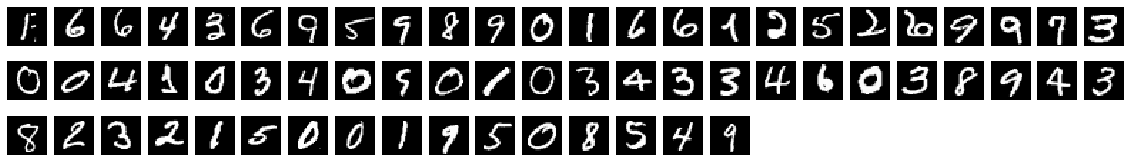

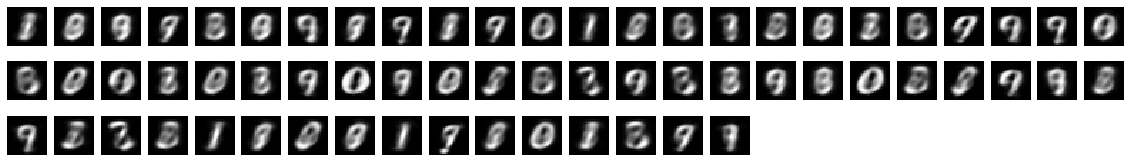

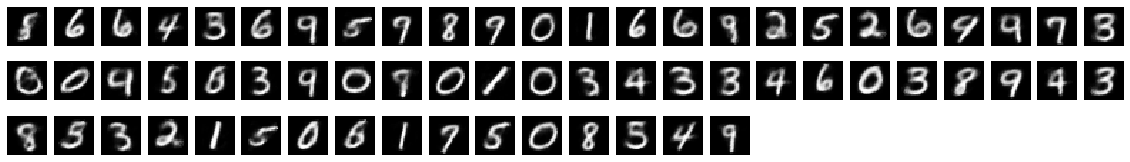

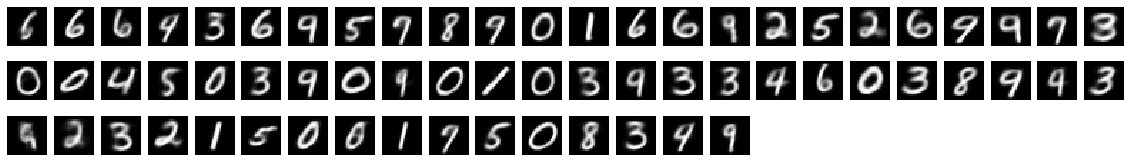

In [43]:
# plot the digits of the first BATCHES_PLT batches
BATCHES_PLT = 1

with no_grad():
    for batch, (data, labels) in enumerate(train_loader):
        # observed
        obs_image = data.view(-1, 784).to(dev)
        show_images(obs_image)
        plt.show()
        # predicted
        for t, trained_model in enumerate(trained_models):
            _, pred_image = trained_model(obs_image)
            show_images(pred_image)
            plt.show()
        if batch+1 >= BATCHES_PLT: break

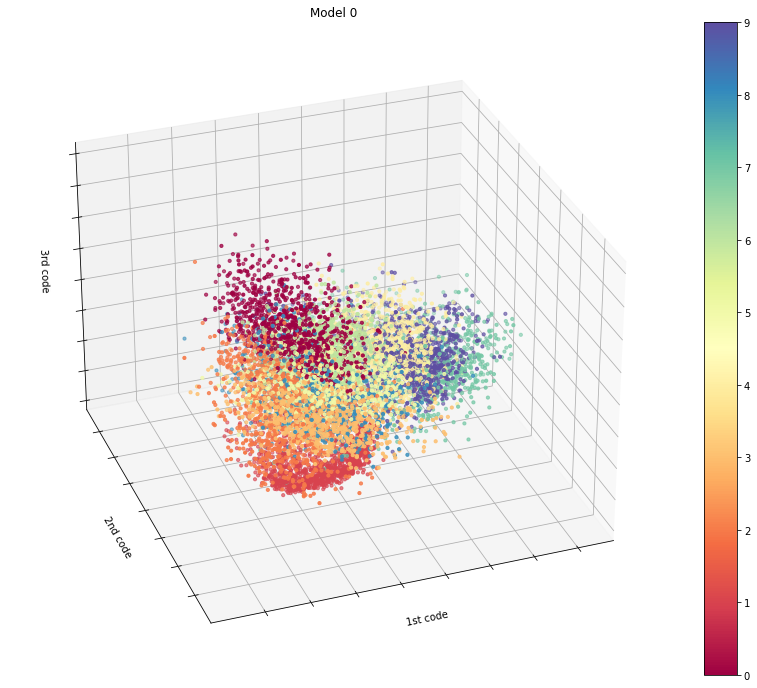

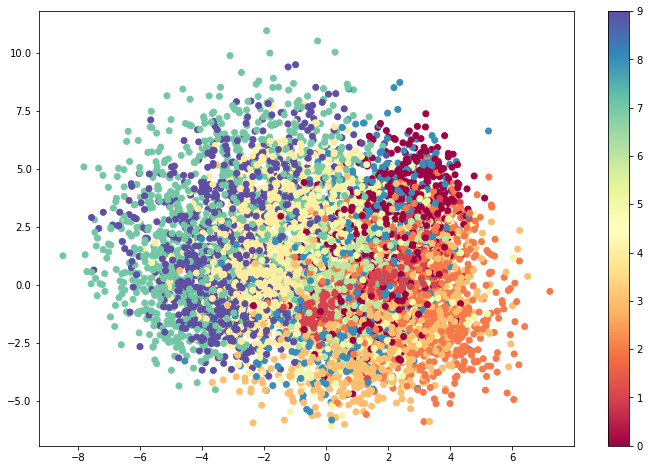

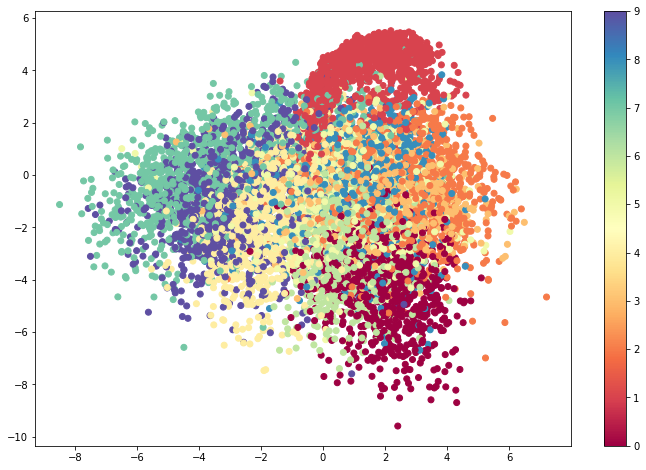

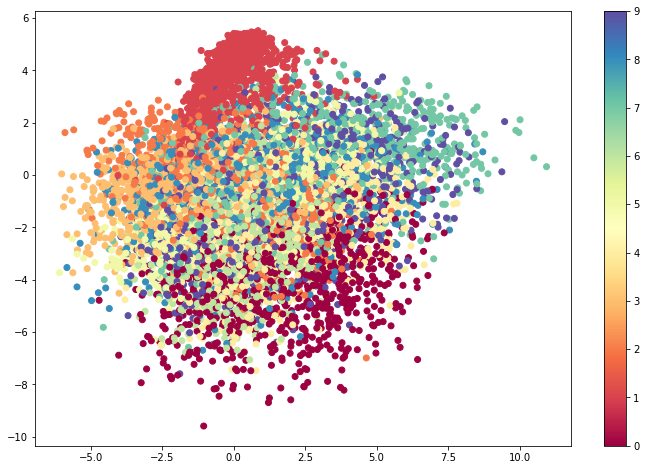

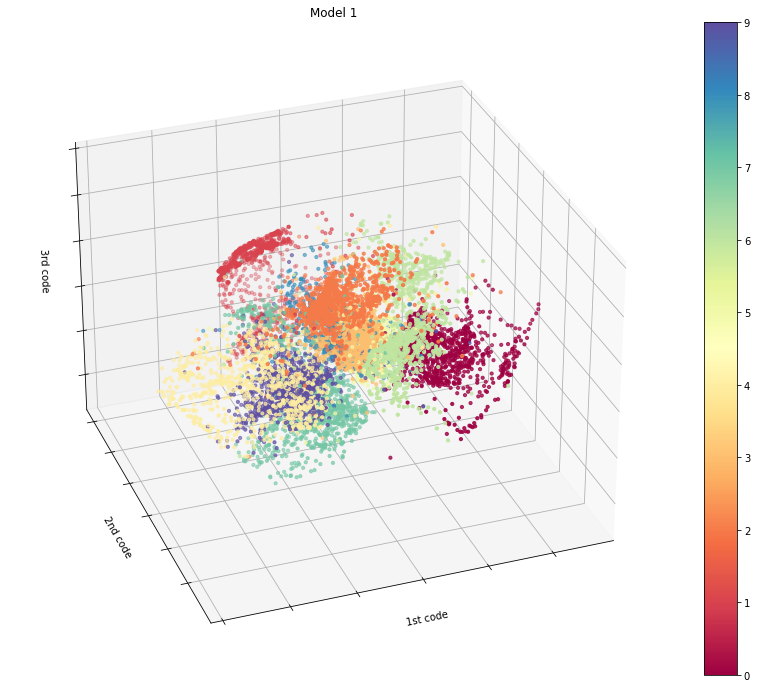

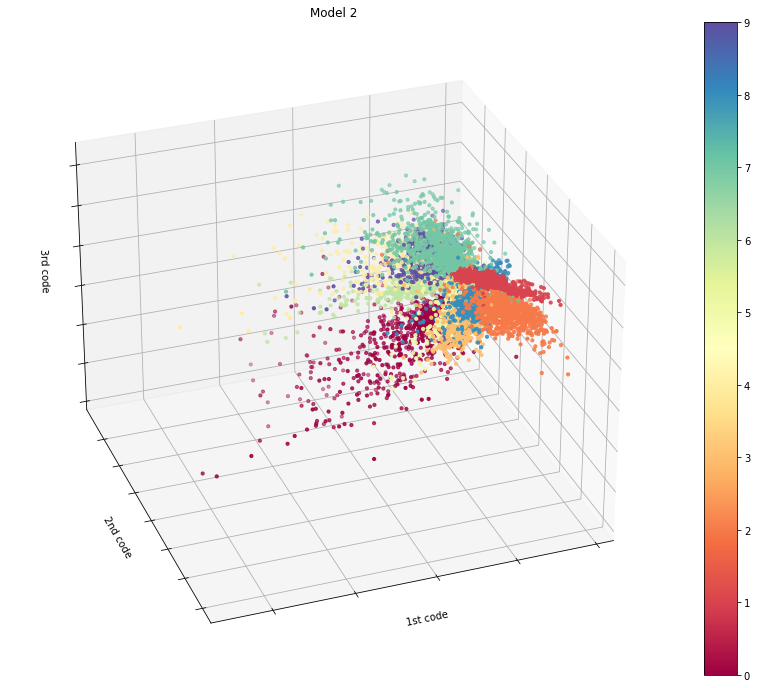

In [23]:
# scatters with TEST dataset
for t, trained_model in enumerate(trained_models):
    axis_x = []
    axis_y = []
    axis_z = []
    answers = []
    with no_grad():
        for data, labels in test_loader:
            inputs = data.view(-1, 784)
            answers += labels.tolist()
            encoded, _ = trained_model(inputs)
            axis_x += encoded[:, 0].tolist()
            axis_y += encoded[:, 1].tolist()
            axis_z += encoded[:, 2].tolist()
    fig = plt.figure(1, figsize=(16, 12))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
    plot = ax.scatter(
           axis_x,
           axis_y,
           axis_z,
           c=answers,
           cmap='Spectral',
           edgecolor=None,
           s=10,
    )
    ax.set_title(f"Model {t}")
    ax.set_xlabel("1st code")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd code")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd code")
    ax.zaxis.set_ticklabels([])
    fig.colorbar(plot)
    plt.savefig(f"imgs/ae-{t}.png")
    plt.show()
    if t == 0:
        # special case for linear AE
        plt.rcParams['figure.figsize'] = (12, 8)
        plt.rcParams['image.cmap'] = 'Spectral'
        plt.scatter(axis_x, axis_y, c=answers)
        plt.colorbar()
        plt.show()
        plt.scatter(axis_x, axis_z, c=answers)
        plt.colorbar()
        plt.show()
        plt.scatter(axis_y, axis_z, c=answers)
        plt.colorbar()
        plt.show()

### Train data plots for PCA comparison

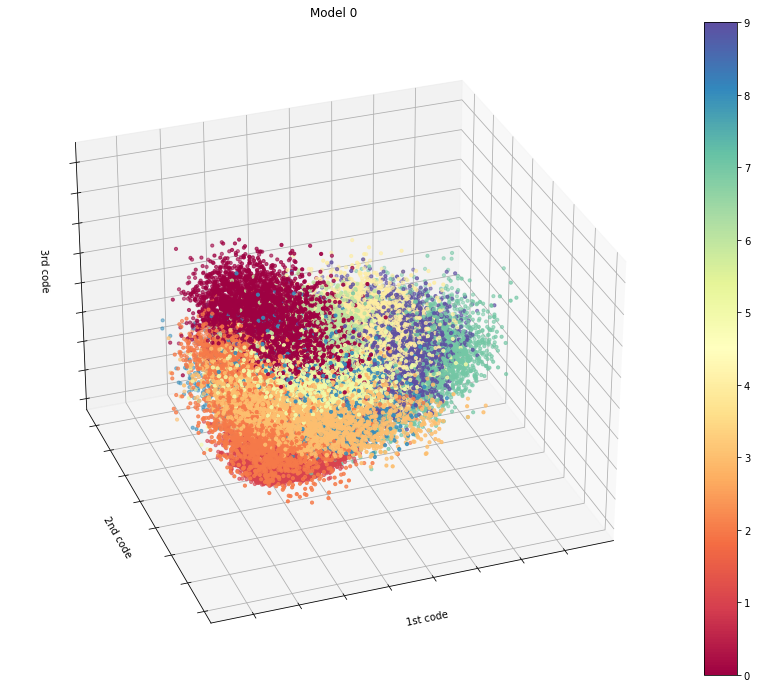

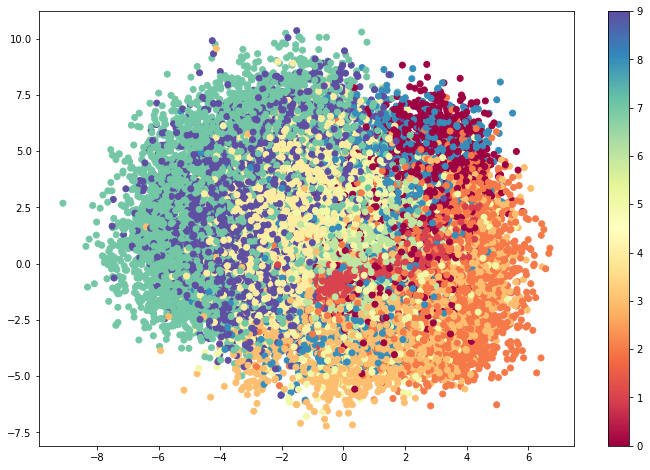

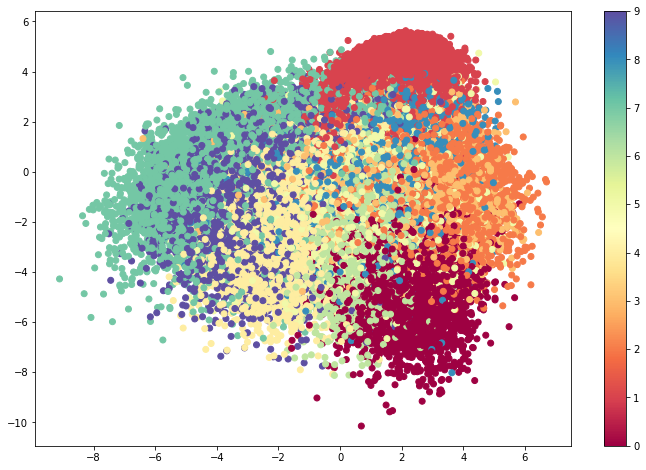

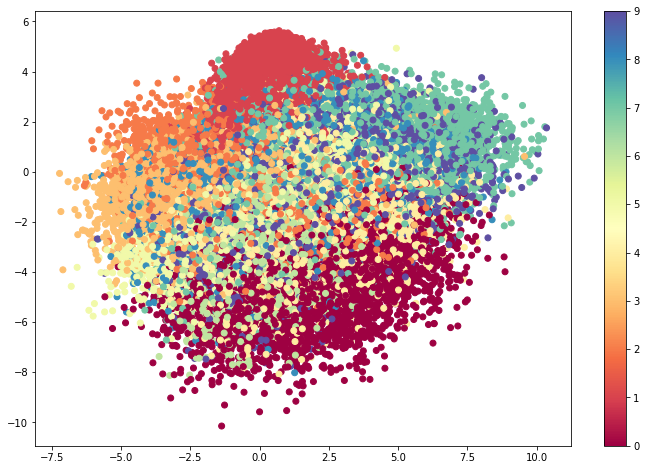

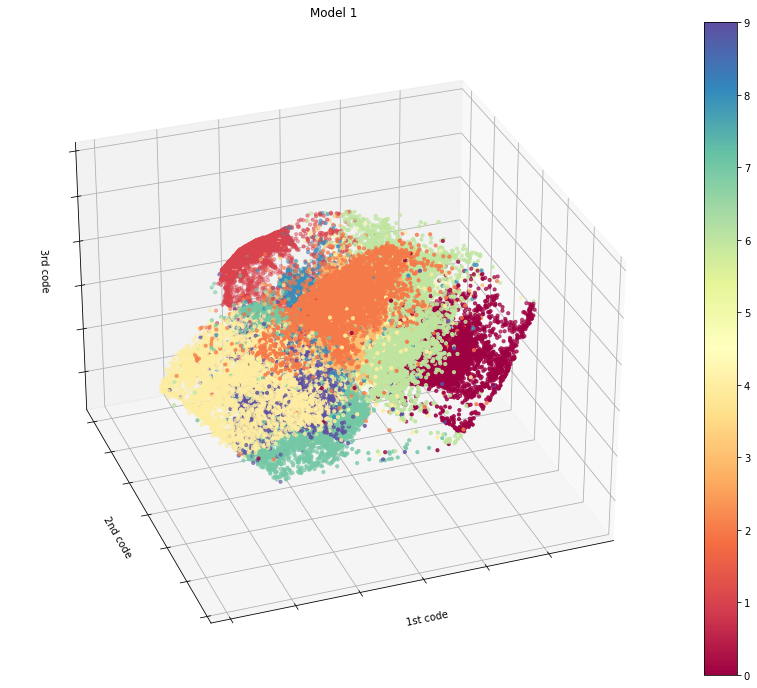

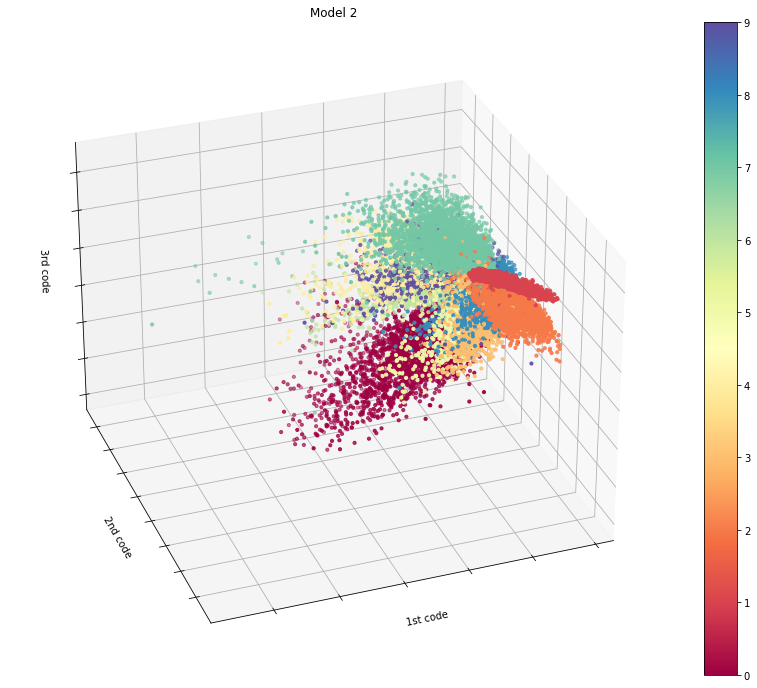

In [24]:
# scatters with TRAIN dataset
for t, trained_model in enumerate(trained_models):
    axis_x = []
    axis_y = []
    axis_z = []
    answers = []
    with no_grad():
        for data, labels in train_loader:
            inputs = data.view(-1, 784)
            answers += labels.tolist()
            encoded, _ = trained_model(inputs)
            axis_x += encoded[:, 0].tolist()
            axis_y += encoded[:, 1].tolist()
            axis_z += encoded[:, 2].tolist()
    fig = plt.figure(1, figsize=(16, 12))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
    plot = ax.scatter(
           axis_x,
           axis_y,
           axis_z,
           c=answers,
           cmap='Spectral',
           edgecolor=None,
           s=10,
    )
    ax.set_title(f"Model {t}")
    ax.set_xlabel("1st code")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd code")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd code")
    ax.zaxis.set_ticklabels([])
    fig.colorbar(plot)
    plt.savefig(f"imgs/ae-{t}.png")
    plt.show()
    if t == 0:
        # special case for the linear AE
        plt.rcParams['figure.figsize'] = (12, 8)
        plt.rcParams['image.cmap'] = 'Spectral'
        plt.scatter(axis_x, axis_y, c=answers)
        plt.colorbar()
        plt.show()
        plt.scatter(axis_x, axis_z, c=answers)
        plt.colorbar()
        plt.show()
        plt.scatter(axis_y, axis_z, c=answers)
        plt.colorbar()
        plt.show()

### Experiment - Random pixel values?

- If the AE was trained with hand-wirtten digits, what would happen if it received a non-digit input? Why?

Input -> Reconstruction



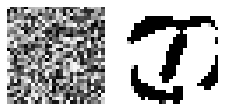

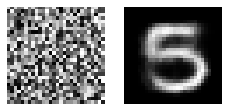

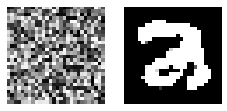

In [32]:
print('Input -> Reconstruction\n')

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.axis('off')

def show_images(images):
    for index, image in enumerate(images):
        plt.subplot(1, 4, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')

with no_grad():
    for t in trained_models:
        rnd_data = randint(0,255,(1,784), dtype=float32)
        _, pred_image = t(rnd_data)
        show_images([rnd_data,pred_image])
        plt.show()